# BERT classification

# Table of Contents
## [Notebook Introduction](#intro)
## [Data Preprocessing](#preprocessing)
## [Modeling](#bert)
## [Conclusion and Future Actions](#next)

<a id=Intro></a>
## Notebook Introduction
The purpose of this notebook is to explore and experiment with neural networks, and finetuning of a pre-trained model, BERT to classify reviews. There is a restriction to this type of modeling for this dataset and that is it could only evaluate based on one column which will be `review_body` in this case and not `review_headline` or any other features.

<a id="data"></a>
## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import scipy.sparse as sp
import shutil
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # To get rid of error messages
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Limit GPU memory to avoid memory issue
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
# check if GPU is being used
len(tf.config.list_physical_devices('GPU'))>0

True

In [4]:
# Load the dataframes
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)
df

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
0,Minnetonka Men's Double Deerskin Softsole Mocc...,1,0,0,1,,do not buy really didn t start to wear them u...,2015.0,8.0
1,Teva Men's Pajaro Flip-Flop,5,0,0,1,super flip flop,provides great cushion as well as archsupport,2015.0,8.0
3,adidas Men's 10K Lifestyle Runner Sneaker,5,0,6,1,badass,getting what u see,2015.0,8.0
4,OverBling Sneakers for Men Casual Men Shoes Ge...,3,0,0,1,three stars,small,2015.0,8.0
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),5,1,1,1,five stars,my 13 year old son loved these shoes excellent...,2015.0,8.0
...,...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,1,0,0,0,what a waste,i purchased this shoe because it looked good ...,2002.0,10.0
4358811,Women's Bree Suede Moc Snow Joggers,5,1,1,0,you want it you need it,this little shoe boot is so great if you re th...,2002.0,10.0
4358812,Women's CanvasMule Shoes,5,0,0,0,cute,the backless mule is very comfortable cute ...,2002.0,9.0
4358813,Birki's Super Birki Unisex Clog,5,10,11,0,graceless and immense comfy and cool,my garden clogs make my feet look huge and ev...,2002.0,3.0


In [5]:
with open('2ClassDf.pkl', 'rb') as f:
    df2 = pickle.load(f)
df2

,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,year,month
0,Minnetonka Men's Double Deerskin Softsole Mocc...,0,0,0,1,,do not buy really didn t start to wear them u...,2015.0,8.0
1,Teva Men's Pajaro Flip-Flop,1,0,0,1,super flip flop,provides great cushion as well as archsupport,2015.0,8.0
3,adidas Men's 10K Lifestyle Runner Sneaker,1,0,6,1,badass,getting what u see,2015.0,8.0
4,OverBling Sneakers for Men Casual Men Shoes Ge...,0,0,0,1,three stars,small,2015.0,8.0
5,MESSI 15.3 FG/AG SOCCER SHOES (8.5),1,1,1,1,five stars,my 13 year old son loved these shoes excellent...,2015.0,8.0
...,...,...,...,...,...,...,...,...,...
4358810,Women's Evette Mid-Shaft Boots,0,0,0,0,what a waste,i purchased this shoe because it looked good ...,2002.0,10.0
4358811,Women's Bree Suede Moc Snow Joggers,1,1,1,0,you want it you need it,this little shoe boot is so great if you re th...,2002.0,10.0
4358812,Women's CanvasMule Shoes,1,0,0,0,cute,the backless mule is very comfortable cute ...,2002.0,9.0
4358813,Birki's Super Birki Unisex Clog,1,10,11,0,graceless and immense comfy and cool,my garden clogs make my feet look huge and ev...,2002.0,3.0


In [6]:
# Dropping all columns except review_body
reviews_df = df2.drop(columns=['product_title', 'helpful_votes', 'total_votes', 'review_headline', 'verified_purchase', 'year', 'month'])

In [7]:
bad_rating = reviews_df[reviews_df['star_rating']==0].sample(5000, random_state=1)
good_rating = reviews_df[reviews_df['star_rating']==1].sample(5000, random_state=1) 

reviews_df = pd.concat([bad_rating, good_rating])

In [8]:
# # THIS IS FULL DATASET WHICH TAKES TOO LONG TO RUN SO WILL SKIP
# # Grabbing the size of 0 class to downsample class 1 to
# size = reviews_df[reviews_df['star_rating']==0].shape[0]
# size

# bad_rating = reviews_df[reviews_df['star_rating']==0]
# good_rating = reviews_df[reviews_df['star_rating']==1].sample(size, random_state=1)

# reviews_df = pd.concat([bad_rating, good_rating])

# # sanity check
# reviews_df

In [8]:
# assigning Reviewer_Score as target variable and everything else as X
X = reviews_df.drop(columns=['star_rating'])
y = reviews_df['star_rating']

In [9]:
# splitting the data
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.2, random_state=1, stratify=y_remainder)

<a id="bert"></a>
## Modeling

The code below is based on https://www.tensorflow.org/text/tutorials/classify_text_with_bert. It was of course modified to better suit this dataset as the architecture of the neural networks needed to be changed.

In [10]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [21]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    # net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [22]:
classifier_model = build_classifier_model()
# TESTING THE MODEL
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6007275]], shape=(1, 1), dtype=float32)


In [23]:
# Setting the loss and metrics functions for 2 class classification
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

Since the dataset is in dataframes right now, they have to be converted into tensors to be used with the model.

In [25]:
# have to make the train, validation, and test data into tensor 
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)   # batch size
# cache and prefetch to help in efficiency by using memory
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  # tf.data.AUTOTUNE will use tensorflow to set a recommended buffer_size
# repeat for validation set
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(32)   # batch size
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# repeat for test set
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)    # batch size
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
# setting the optimizer parameters
epochs = 10   # 10 iterations 
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()  # steps per epoch based on the number of elements of the training dataset
num_train_steps = steps_per_epoch * epochs    # num_train_steps for num_warmup_steps
num_warmup_steps = int(0.1*num_train_steps)   # using 10% of the total number of train steps as warmup steps
init_lr = 3e-5     # Setting the learning rate
# Creating the optimizer now that the parameter variables have been set 
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# Compile the model 
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

The model is now ready to be fitted and finetuned.

In [29]:
print(f'Training model with {tfhub_handle_encoder}')
# Set a the model to a variable as information and metrics can be extracted from the model after  
history = classifier_model.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
200/200 [==============================] - 207s 946ms/step - loss: 0.5545 - binary_accuracy: 0.6913 - val_loss: 0.4479 - val_binary_accuracy: 0.8106
Epoch 2/10
200/200 [==============================] - 190s 950ms/step - loss: 0.4116 - binary_accuracy: 0.8152 - val_loss: 0.4110 - val_binary_accuracy: 0.8319
Epoch 3/10
200/200 [==============================] - 190s 951ms/step - loss: 0.3223 - binary_accuracy: 0.8687 - val_loss: 0.4832 - val_binary_accuracy: 0.8156
Epoch 4/10
200/200 [==============================] - 190s 951ms/step - loss: 0.2447 - binary_accuracy: 0.9102 - val_loss: 0.5196 - val_binary_accuracy: 0.8119
Epoch 5/10
200/200 [==============================] - 190s 950ms/step - loss: 0.1705 - binary_accuracy: 0.9434 - val_loss: 0.5967 - val_binary_accuracy: 0.8150
Epoch 6/10
200/200 [==============================] - 190s 950ms/step - loss: 0.1256 - binary_accuracy: 0.9595 - val_

In [30]:
# Test the model
loss, accuracy = classifier_model.evaluate(test_ds)

63/63 [==============================] - 19s 308ms/step - loss: 0.9389 - binary_accuracy: 0.8020


In [31]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.9388707280158997
Accuracy: 0.8019999861717224


In [32]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [33]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

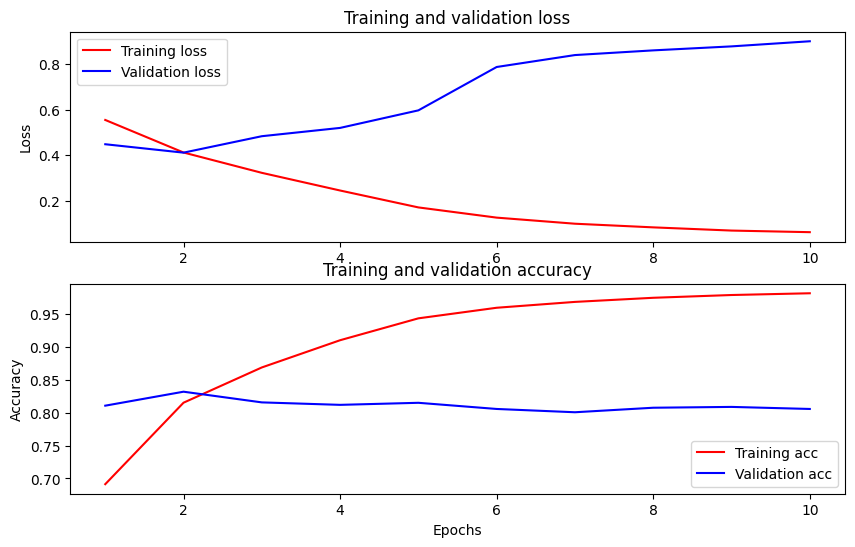

In [34]:
# Visualizing the loss and acucracy per epoch
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

As can be seen from the graphs above, after the 2nd epoch, the validation set performs worse in loss and accuracy whereas training set is performing better in decreasing loss and increasing accuracy. This is a sign of overfitting and it shows when the test dataset was evaluated where the loss was 0.9389 and accuracy was 80.20 which isn't a bad accuracy but the high loss value means that the model isn't confident in predicting.  

In [35]:
# saving the models
with open('BERT1.pkl', 'wb') as f:
    pickle.dump(history, f)

To reduce the overfitting, a dropout layer will be added between each hidden layer to see if it has an effect.

In [63]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net) # dropout layer
    net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net) # dropout layer
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net) # dropout layer
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

In [104]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [105]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [67]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [68]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [69]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
64/64 [==============================] - 1489s 23s/step - loss: 0.5983 - binary_accuracy: 0.6734 - val_loss: 0.4556 - val_binary_accuracy: 0.8062
Epoch 2/10
64/64 [==============================] - 1488s 23s/step - loss: 0.4309 - binary_accuracy: 0.8191 - val_loss: 0.4361 - val_binary_accuracy: 0.8156
Epoch 3/10
64/64 [==============================] - 1508s 24s/step - loss: 0.3487 - binary_accuracy: 0.8628 - val_loss: 0.4610 - val_binary_accuracy: 0.8163
Epoch 4/10
64/64 [==============================] - 1512s 24s/step - loss: 0.2929 - binary_accuracy: 0.8894 - val_loss: 0.4892 - val_binary_accuracy: 0.8169
Epoch 5/10
64/64 [==============================] - 1523s 24s/step - loss: 0.2473 - binary_accuracy: 0.9091 - val_loss: 0.5980 - val_binary_accuracy: 0.8006
Epoch 6/10
64/64 [==============================] - 1522s 24s/step - loss: 0.1718 - binary_accuracy: 0.9445 - val_loss: 0.6395 - val

In [70]:
loss, accuracy = classifier_model.evaluate(test_ds)

20/20 [==============================] - 153s 8s/step - loss: 0.8467 - binary_accuracy: 0.7825


In [71]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.8467469215393066
Accuracy: 0.7825000286102295


The loss had indeed decrease but so did accuracy which is fine as it only dropped ~1% in accuracy but decreased by ~.10 for loss.

In [72]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [73]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

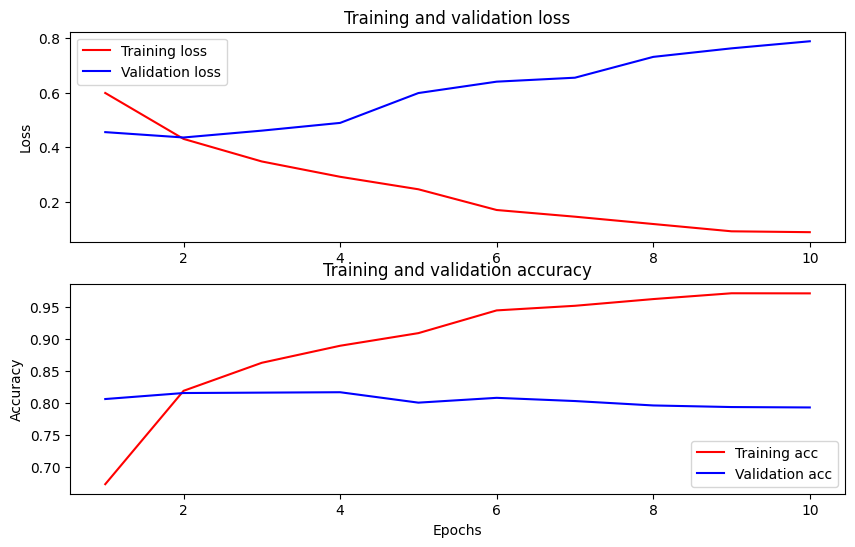

In [74]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

The graphs above are similar to the first ones so although the test dataset showed a decrease in loss, the model is still overfitting to the train dataset. To keep the notebook clean and concise, the next model to be displayed was the best model out of over 20 models that were ran with various arctitectures and hidden layers. The result was a somewhat simple architecture and wasn't too complex.

In [150]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.batch(32)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_ds = valid_ds.batch(32)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model4 = build_classifier_model()

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [ ]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model4.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [170]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model4.fit(x=train_ds, validation_data=valid_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/10
20/20 [==============================] - 181s 8s/step - loss: 0.8256 - binary_accuracy: 0.4859 - val_loss: 0.7018 - val_binary_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 161s 8s/step - loss: 0.7693 - binary_accuracy: 0.4578 - val_loss: 0.6904 - val_binary_accuracy: 0.4938
Epoch 3/10
20/20 [==============================] - 160s 8s/step - loss: 0.7230 - binary_accuracy: 0.5063 - val_loss: 0.6767 - val_binary_accuracy: 0.6313
Epoch 4/10
20/20 [==============================] - 159s 8s/step - loss: 0.7052 - binary_accuracy: 0.5391 - val_loss: 0.6575 - val_binary_accuracy: 0.6187
Epoch 5/10
20/20 [==============================] - 161s 8s/step - loss: 0.6486 - binary_accuracy: 0.6109 - val_loss: 0.6217 - val_binary_accuracy: 0.7000
Epoch 6/10
20/20 [==============================] - 160s 8s/step - loss: 0.5839 - binary_accuracy: 0.6969 - val_loss: 0.5736 - val_binary_accu

In [172]:
loss, accuracy = classifier_model4.evaluate(test_ds)

7/7 [==============================] - 16s 2s/step - loss: 0.4934 - binary_accuracy: 0.7950


In [173]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.49336913228034973
Accuracy: 0.7950000166893005


Huge improvement in terms of loss when compared to other models that were ran with values mainly ranging from 0.8 to 1.1. The accuracy is also quite good with 79.50% which is similar score as previous models that were ran but at least this model has the lowest loss.

In [175]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


In [176]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

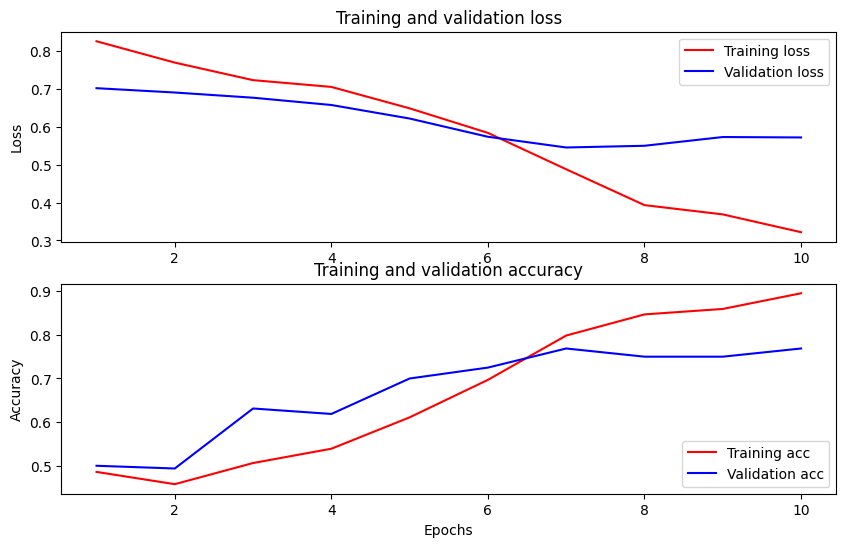

In [177]:
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

This was the best model as the training and validation set seems to perform similar in that in the graph above, the lines are coinciding and have similar results in each epoch. Thus, this model isn't overfitting like previous models. 

<a id="next"></a>
## Conclusion and Future Steps

Surprisingly, the results of using BERT wasn't as expected as the best test accuracy isn't that impressive as the test score accuracy is again ~80% just like other models and the loss is ~.5 which is also not too great. Therefore, the best model out of every model that was ran would probably be the downsampled logisitic regression as the test score was around 80% with a good result in precision and recall to back it up. 

It seemed to be that every model had capped at around 80% test score accuracy so it could be the dataset itself or maybe something inherent to reviews (what was lightly explored in Downsampled Modeling by looking at inaccurate predictions). In the future, this could be explored as well as creating prediction system based on the original 5 star rating scores. Another thing that could be done is segment based on shoe type as the dataset is an aggregate of every type of shoes (such as running shoes, hiking shoes and dress shoes). This could possibly be done with Hugging Face and clustering, like what was explored in `Cleaning Data.ipynb` but with fine-tuning to increase performance. Finetuning BERT to start predicting key features instead of having to go through a list of words and manually extract key words is also something that could be explored. Finally, running the full dataset with all these models (if computationally possible) to see if it could help the models in prediction with more training data.